# League of Legends - Analyzing My Personal Gameplay Data

What kind of actionable insights can I take away from analyzing my personal gameplay data? As a player that only plays one champion (Kayle OTP), I wanted to focus on my ranked games with Kayle, to see if there were any findings that I could take to mold my gameplay and climb the ranked ladder.

Due to the nature of Kayle being a hyper-scaling, late-game orientated champion, I had several preconceived notions I wanted to test: damage dealt to champions would be higher in wins than losses, my chances for winning would increase as games dragged on, and that my creep score per minute was higher in wins.

In [1]:
#importing libraries

import json
import requests
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#https://developer.riotgames.com/

#API key is only valid for 24 hours
api_key = 'RGAPI-f72b1d8a-ed77-44e6-bb50-eb7cdaff1a3f'

#IGN
summoner_name = 'dTian'

#region
my_region = 'na1'

#Kayle's champion code
champ_code = 10

#Ranked Solo/Duo code
ranked_solo_code = 420

In [3]:
#uncomment the below cell if riotwatcher hasn't been installed

# pip install riotwatcher

In [4]:
#let's first see if we can pull up my profile

from riotwatcher import LolWatcher, ApiError

watcher = LolWatcher(api_key)

me = watcher.summoner.by_name(my_region, summoner_name)
print(me)

# all objects are returned (by default) as a dict
# lets see if i got diamond yet (i probably didnt)
my_ranked_stats = watcher.league.by_summoner(my_region, me['id'])
print(my_ranked_stats)

# First we get the latest version of the game from data dragon
versions = watcher.data_dragon.versions_for_region(my_region)
champions_version = versions['n']['champion']

try:
    response = watcher.summoner.by_name(my_region, summoner_name)
except ApiError as err:
    if err.response.status_code == 429:
        print('We should retry in {} seconds.'.format(err.response.headers['Retry-After']))
        print('this retry-after is handled by default by the RiotWatcher library')
        print('future requests wait until the retry-after time passes')
    elif err.response.status_code == 404:
        print('Summoner with that ridiculous name not found.')
    else:
        raise

{'id': 'd3lAVQL64CPQCtcih5hwaiYJMQF8ImzlfaKZt3sQdNUC9B8', 'accountId': 'eNXPtKlyIp51UDb8eD8EihXDXMY1hz0r4Rtyqd55zVjnze0', 'puuid': 'XzQgfcczP2tDhKQ4kuWAnDHdAGwLTYF-zK3kck_kfBVZxp6r_tQnpOeHQGfo0d7w5qT5KFGe3eRwSw', 'name': 'dTian', 'profileIconId': 21, 'revisionDate': 1626060786677, 'summonerLevel': 292}
[{'leagueId': '283fc30c-ef8b-42ea-a7a8-0f5bf225fe95', 'queueType': 'RANKED_FLEX_SR', 'tier': 'DIAMOND', 'rank': 'III', 'summonerId': 'd3lAVQL64CPQCtcih5hwaiYJMQF8ImzlfaKZt3sQdNUC9B8', 'summonerName': 'dTian', 'leaguePoints': 27, 'wins': 74, 'losses': 61, 'veteran': False, 'inactive': False, 'freshBlood': False, 'hotStreak': True}, {'leagueId': '871049b2-f23c-4b71-a4fc-428612580494', 'queueType': 'RANKED_SOLO_5x5', 'tier': 'DIAMOND', 'rank': 'II', 'summonerId': 'd3lAVQL64CPQCtcih5hwaiYJMQF8ImzlfaKZt3sQdNUC9B8', 'summonerName': 'dTian', 'leaguePoints': 26, 'wins': 641, 'losses': 623, 'veteran': False, 'inactive': False, 'freshBlood': False, 'hotStreak': False}]


In [5]:
#let's first try to see the data regarding my latest match

my_matches = watcher.match.matchlist_by_account(my_region, me['accountId'])

# fetch last match detail
last_match = my_matches['matches'][0]
match_detail = watcher.match.by_id(my_region, last_match['gameId'])

participants = []
for row in match_detail['participants']:
    participants_row = {}
    participants_row['champion'] = row['championId']
    participants_row['spell1'] = row['spell1Id']
    participants_row['spell2'] = row['spell2Id']
    participants_row['win'] = row['stats']['win']
    participants_row['kills'] = row['stats']['kills']
    participants_row['deaths'] = row['stats']['deaths']
    participants_row['assists'] = row['stats']['assists']
    participants_row['totalDamageDealtToChampions'] = row['stats']['totalDamageDealtToChampions']
    participants_row['goldEarned'] = row['stats']['goldEarned']
    participants_row['champLevel'] = row['stats']['champLevel']
    participants_row['totalMinionsKilled'] = row['stats']['totalMinionsKilled']
    participants_row['longestTimeSpentLiving'] = row['stats']['longestTimeSpentLiving']
    participants_row['champLevel'] = row['stats']['champLevel']
    participants_row['visionWardsBoughtInGame'] = row['stats']['visionWardsBoughtInGame']
    participants_row['firstBloodKill'] = row['stats']['firstBloodKill']
    participants_row['firstBloodAssist'] = row['stats']['firstBloodAssist']
    participants_row['damageTakenPerMinDeltas'] = row['timeline']['damageTakenPerMinDeltas']
    participants.append(participants_row)
df = pd.DataFrame(participants)
df

,champion,spell1,spell2,win,kills,deaths,assists,totalDamageDealtToChampions,goldEarned,champLevel,totalMinionsKilled,longestTimeSpentLiving,visionWardsBoughtInGame,firstBloodKill,firstBloodAssist,damageTakenPerMinDeltas
0,432,14,4,True,1,5,15,8068,7634,13,45,306,6,False,False,"{'10-20': 464.5, '0-10': 409.6}"
1,517,12,4,True,8,4,11,18537,12878,15,141,558,1,False,False,"{'10-20': 1011.7, '0-10': 562.2}"
2,876,11,4,True,10,4,10,20677,13210,15,47,443,3,True,False,"{'10-20': 1118.7, '0-10': 1083.3}"
3,222,7,4,True,8,7,8,21519,11451,13,141,560,5,False,False,"{'10-20': 810.0999999999999, '0-10': 353.2}"
4,92,14,4,True,7,1,11,20402,13597,15,168,1087,0,False,False,"{'10-20': 621.2, '0-10': 306.4}"
5,350,14,3,False,0,5,12,7131,6182,11,46,472,4,False,False,"{'10-20': 171.9, '0-10': 271.4}"
6,64,11,4,False,11,7,5,23699,13307,13,53,747,3,False,False,"{'10-20': 1571.1, '0-10': 749.2}"
7,267,4,14,False,2,4,12,9668,7175,12,16,477,2,False,False,"{'10-20': 355.5, '0-10': 386.7}"
8,234,14,4,False,2,9,4,12453,8431,13,146,273,2,False,False,"{'10-20': 989.7, '0-10': 599.9}"
9,96,4,7,False,5,9,8,22823,10648,13,183,310,3,False,False,"{'10-20': 692, '0-10': 475.70000000000005}"


In [6]:
#exploring the different data fields for a match
match_detail

{'gameId': 3973933717,
 'platformId': 'NA1',
 'gameCreation': 1626034987870,
 'gameDuration': 1635,
 'queueId': 420,
 'mapId': 11,
 'seasonId': 13,
 'gameVersion': '11.14.385.9967',
 'gameMode': 'CLASSIC',
 'gameType': 'MATCHED_GAME',
 'teams': [{'teamId': 100,
   'win': 'Win',
   'firstBlood': True,
   'firstTower': True,
   'firstInhibitor': True,
   'firstBaron': True,
   'firstDragon': True,
   'firstRiftHerald': True,
   'towerKills': 11,
   'inhibitorKills': 3,
   'baronKills': 1,
   'dragonKills': 3,
   'vilemawKills': 0,
   'riftHeraldKills': 1,
   'dominionVictoryScore': 0,
   'bans': [{'championId': 164, 'pickTurn': 1},
    {'championId': 39, 'pickTurn': 2},
    {'championId': 89, 'pickTurn': 3},
    {'championId': 117, 'pickTurn': 4},
    {'championId': 203, 'pickTurn': 5}]},
  {'teamId': 200,
   'win': 'Fail',
   'firstBlood': False,
   'firstTower': False,
   'firstInhibitor': False,
   'firstBaron': False,
   'firstDragon': False,
   'firstRiftHerald': False,
   'towerKil

In [7]:
#let's expand this to download 500 games worth of data
my_matches_first100 = watcher.match.matchlist_by_account(my_region, me['accountId'], begin_index=0, end_index=100, 
                                                         champion=champ_code, queue=ranked_solo_code)
my_matches_second100 = watcher.match.matchlist_by_account(my_region, me['accountId'], begin_index=100, end_index=200,
                                                          champion=champ_code, queue=ranked_solo_code)
my_matches_third100 = watcher.match.matchlist_by_account(my_region, me['accountId'], begin_index=200, end_index=300, 
                                                         champion=champ_code, queue=ranked_solo_code)
my_matches_fourth100 = watcher.match.matchlist_by_account(my_region, me['accountId'], begin_index=300, end_index=400, 
                                                         champion=champ_code, queue=ranked_solo_code)
my_matches_fifth100 = watcher.match.matchlist_by_account(my_region, me['accountId'], begin_index=400, end_index=500, 
                                                         champion=champ_code, queue=ranked_solo_code)

total_game_ids = []
for match in my_matches_first100['matches']:
    total_game_ids.append(match['gameId'])
for match in my_matches_second100['matches']:
    total_game_ids.append(match['gameId'])
for match in my_matches_third100['matches']:
    total_game_ids.append(match['gameId'])
for match in my_matches_fourth100['matches']:
    total_game_ids.append(match['gameId'])
for match in my_matches_fifth100['matches']:
    total_game_ids.append(match['gameId'])

len(total_game_ids)

500

In [8]:
#now let's put all 500 matches into a dataframe
personal_data = []

for game_id in total_game_ids:
    match_detail = watcher.match.by_id(my_region, game_id)
    for row in match_detail['participants']:
        personal_data_row = {}
        allyTeam = []
        enemyTeam = []
        allyChamps = []
        enemyChamps = []
        if row['championId'] == champ_code:
            personal_data_row['champion'] = row['championId']
            personal_data_row['gameDuration'] = match_detail['gameDuration']
            personal_data_row['win'] = row['stats']['win']
            personal_data_row['totalDamageDealtToChampions'] = row['stats']['totalDamageDealtToChampions']
            personal_data_row['goldEarned'] = row['stats']['goldEarned']
            personal_data_row['champLevel'] = row['stats']['champLevel']
            personal_data_row['totalMinionsKilled'] = row['stats']['totalMinionsKilled']
            personal_data_row['longestTimeSpentLiving'] = row['stats']['longestTimeSpentLiving']
            personal_data_row['champLevel'] = row['stats']['champLevel']
            personal_data_row['teamColor'] = row['teamId']
            personal_data_row['visionWardsBoughtInGame'] = row['stats']['visionWardsBoughtInGame']
            try:
                personal_data_row['firstBloodKill'] = row['stats']['firstBloodKill']
            except:
                personal_data_row['firstBloodKill'] = np.nan
            try:
                personal_data_row['firstBloodAssist'] = row['stats']['firstBloodAssist']
            except:
                personal_data_row['firstBloodAssist'] = np.nan
            try:
                personal_data_row['damageTakenPerMinDeltas 0-10'] = row['timeline']['damageTakenPerMinDeltas']['0-10']
            except:
                personal_data_row['damageTakenPerMinDeltas 0-10'] = np.nan
            try:
                personal_data_row['creepsPerMinDeltas 0-10'] = row['timeline']['creepsPerMinDeltas']['0-10']
            except:
                personal_data_row['creepsPerMinDeltas 0-10'] = np.nan
            try:
                personal_data_row['damageTakenPerMinDeltas 10-20'] = row['timeline']['damageTakenPerMinDeltas']['10-20']
            except:
                personal_data_row['damageTakenPerMinDeltas 10-20'] = np.nan
            try:
                personal_data_row['damageTakenPerMinDeltas 20-30'] = row['timeline']['damageTakenPerMinDeltas']['20-30']
            except:
                personal_data_row['damageTakenPerMinDeltas 20-30'] = np.nan
            try:
                personal_data_row['creepsPerMinDeltas 10-20'] = row['timeline']['creepsPerMinDeltas']['10-20']
            except:
                personal_data_row['creepsPerMinDeltas 10-20'] = np.nan
            try:
                personal_data_row['creepsPerMinDeltas 20-30'] = row['timeline']['creepsPerMinDeltas']['20-30']
            except:
                personal_data_row['creepsPerMinDeltas 20-30'] = np.nan
            if row['teamId'] == 100:
                for x in range (0,5):
                    allyTeam.append(match_detail['participantIdentities'][x]['player']['summonerName'])
                    allyChamps.append(match_detail['participants'][x]['championId'])
                    personal_data_row['allyTeam'] = allyTeam
                    personal_data_row['allyChamps'] = allyChamps
                for x in range (5,10):
                    enemyTeam.append(match_detail['participantIdentities'][x]['player']['summonerName'])
                    enemyChamps.append(match_detail['participants'][x]['championId'])
                    personal_data_row['enemyTeam'] = enemyTeam
                    personal_data_row['enemyChamps'] = enemyChamps
            else:
                for x in range (5,10):
                    allyTeam.append(match_detail['participantIdentities'][x]['player']['summonerName'])
                    allyChamps.append(match_detail['participants'][x]['championId'])
                    personal_data_row['allyTeam'] = allyTeam
                    personal_data_row['allyChamps'] = allyChamps
                for x in range (0,5):
                    enemyTeam.append(match_detail['participantIdentities'][x]['player']['summonerName'])
                    enemyChamps.append(match_detail['participants'][x]['championId'])
                    personal_data_row['enemyTeam'] = enemyTeam
                    personal_data_row['enemyChamps'] = enemyChamps

            personal_data.append(personal_data_row)
            
df_personal_data = pd.DataFrame(personal_data)
df_personal_data

,champion,gameDuration,win,totalDamageDealtToChampions,goldEarned,champLevel,totalMinionsKilled,longestTimeSpentLiving,teamColor,visionWardsBoughtInGame,...,damageTakenPerMinDeltas 0-10,creepsPerMinDeltas 0-10,damageTakenPerMinDeltas 10-20,damageTakenPerMinDeltas 20-30,creepsPerMinDeltas 10-20,creepsPerMinDeltas 20-30,allyTeam,allyChamps,enemyTeam,enemyChamps
0,10,912,False,5630,4391,8,43,225,200,1,...,518.7,2.7,NaN,NaN,NaN,NaN,"[She my qt , dTian, Disdáin, STREETS ON FIRE, ...","[360, 10, 246, 131, 147]","[Big Zu, pandabear pants, Pellicle, Urpog, Scr...","[67, 164, 120, 6, 16]"
1,10,1542,False,7710,8385,13,163,567,200,2,...,481.6,7.1,800.2,NaN,5.8,NaN,"[Big Zu, victorlzz1997, valksoar, Lanzar, dTian]","[15, 412, 55, 131, 10]","[Jungledog1, Ad Mids, we boolin xd, Muffinhawk...","[115, 157, 126, 104, 43]"
2,10,1532,False,8700,8007,13,120,351,200,0,...,450.6,4.8,562.3,NaN,5.0,NaN,"[gebble is taken, objechtion, dTian, FERV0R, M...","[234, 40, 10, 90, 523]","[Almarea, Moeithy, ˇEli, Liquid Therapy , vic...","[119, 112, 5, 25, 58]"
3,10,1597,True,17426,11607,15,164,448,200,1,...,365.9,6.7,908.6,NaN,7.4,NaN,"[PharmDRPh, Don Scuttersmith, G00BIE, dTian, w...","[117, 145, 103, 10, 5]","[InfamousDMT, Stácy, Areeb, Phalus, Sillody]","[238, 64, 517, 555, 202]"
4,10,1769,True,22599,14735,16,206,906,100,1,...,330.2,7.2,577.8,NaN,9.6,NaN,"[CR Bbi dol ie, GoodNight Bubble, LEEESHINN, d...","[39, 876, 53, 10, 81]","[Skarrom, smiit, Professor Nugg, The Sage, Siz...","[154, 55, 555, 145, 64]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,10,1992,True,15306,13966,17,207,665,200,4,...,296.5,6.5,936.1,1084.2,8.9,3.6,"[dTian, TAIJI Orca, EyeSeeM, Professor Nugg, X...","[10, 105, 121, 555, 145]","[Miskas Phab Ej, xSprintx, Jeanne, Kastelhn, C...","[44, 54, 222, 421, 61]"
496,10,1469,True,7992,10740,15,197,679,100,4,...,340.9,7.1,666.6,NaN,8.2,NaN,"[kat valentíne, TTV geomener900, dTian, Turska...","[55, 107, 10, 147, 18]","[Gochu XL, My captain, XeoChing, Foo Fighters,...","[421, 117, 222, 246, 12]"
497,10,1423,False,11137,8228,14,193,692,200,1,...,418.9,7.2,742.7,NaN,10.0,NaN,"[collectingsalt, Eepblob, dTian, Bowkeeper, Dî...","[45, 51, 10, 120, 53]","[Little Katido, Sup im Carrier, girl destroyer...","[9, 25, 22, 68, 234]"
498,10,1263,True,18435,11701,13,158,821,100,2,...,219.2,7.1,736.8,NaN,7.6,NaN,"[dTian, Lionel messione, Sup im Carrier, leagu...","[10, 120, 147, 498, 3]","[sAvîOr, CheckYourCorners, Hodgie, KSPIRITO, B...","[238, 427, 412, 222, 86]"


In [9]:
# df_personal_data = pd.read_csv('data/500_matches')
# df_personal_data

In [10]:
#manually calculate creep score/min
df_personal_data['csPerMin'] = df_personal_data['totalMinionsKilled'] / (df_personal_data['gameDuration']/60)

In [11]:
#let's download the champion codes in order to figure out which champions are on my team / which champions are on enemy team
import urllib.request, json 
with urllib.request.urlopen("http://ddragon.leagueoflegends.com/cdn/11.8.1/data/en_US/champion.json") as url:
    raw_champ_data = json.loads(url.read().decode())

champ_codes = {}
for champ in raw_champ_data['data'].keys():
    champ_codes[raw_champ_data['data'][champ]['key']] = champ

#convert dict key to int
champ_codes = {int(key): str(value) for key, value in champ_codes.items()}
champ_codes

{266: 'Aatrox',
 103: 'Ahri',
 84: 'Akali',
 12: 'Alistar',
 32: 'Amumu',
 34: 'Anivia',
 1: 'Annie',
 523: 'Aphelios',
 22: 'Ashe',
 136: 'AurelionSol',
 268: 'Azir',
 432: 'Bard',
 53: 'Blitzcrank',
 63: 'Brand',
 201: 'Braum',
 51: 'Caitlyn',
 164: 'Camille',
 69: 'Cassiopeia',
 31: 'Chogath',
 42: 'Corki',
 122: 'Darius',
 131: 'Diana',
 119: 'Draven',
 36: 'DrMundo',
 245: 'Ekko',
 60: 'Elise',
 28: 'Evelynn',
 81: 'Ezreal',
 9: 'Fiddlesticks',
 114: 'Fiora',
 105: 'Fizz',
 3: 'Galio',
 41: 'Gangplank',
 86: 'Garen',
 150: 'Gnar',
 79: 'Gragas',
 104: 'Graves',
 887: 'Gwen',
 120: 'Hecarim',
 74: 'Heimerdinger',
 420: 'Illaoi',
 39: 'Irelia',
 427: 'Ivern',
 40: 'Janna',
 59: 'JarvanIV',
 24: 'Jax',
 126: 'Jayce',
 202: 'Jhin',
 222: 'Jinx',
 145: 'Kaisa',
 429: 'Kalista',
 43: 'Karma',
 30: 'Karthus',
 38: 'Kassadin',
 55: 'Katarina',
 10: 'Kayle',
 141: 'Kayn',
 85: 'Kennen',
 121: 'Khazix',
 203: 'Kindred',
 240: 'Kled',
 96: 'KogMaw',
 7: 'Leblanc',
 64: 'LeeSin',
 89: 'Leona'

In [12]:
#total games with certain allied champs

dict_allyChamp_counts = {}

for x in range(0,len(df_personal_data['allyChamps'].values)):
    for i in range (0,5):
        if df_personal_data['allyChamps'].values[x][i] in dict_allyChamp_counts:
            dict_allyChamp_counts[df_personal_data['allyChamps'].values[x][i]] += 1
        else:
            dict_allyChamp_counts[df_personal_data['allyChamps'].values[x][i]] = 1

dict_allyChamp_counts_sorted = {k: v for k, v in sorted(dict_allyChamp_counts.items(), key=lambda item: item[1], reverse=True)}
dict_allyChamp_counts_sorted

#translates champId into champion name
dict_allyChamp_counts_sorted_translated = {}
for champId in dict_allyChamp_counts_sorted.keys():
    championName = champ_codes[champId]
    dict_allyChamp_counts_sorted_translated[championName] = dict_allyChamp_counts_sorted[champId]
    
dict_allyChamp_counts_sorted_translated

{'Kayle': 500,
 'Jinx': 72,
 'Thresh': 65,
 'Kaisa': 57,
 'Lulu': 46,
 'Tristana': 44,
 'Jhin': 36,
 'Zed': 35,
 'Morgana': 34,
 'LeeSin': 33,
 'Vayne': 33,
 'Khazix': 33,
 'Viego': 32,
 'Ezreal': 32,
 'Kayn': 32,
 'Seraphine': 31,
 'Yone': 31,
 'Senna': 30,
 'Samira': 27,
 'Caitlyn': 27,
 'Leona': 25,
 'Volibear': 24,
 'Nautilus': 24,
 'Graves': 24,
 'Alistar': 24,
 'Diana': 23,
 'Karma': 23,
 'Yuumi': 23,
 'Draven': 22,
 'Sylas': 21,
 'Hecarim': 21,
 'Rumble': 21,
 'Bard': 21,
 'Blitzcrank': 20,
 'Ekko': 20,
 'Galio': 20,
 'Qiyana': 19,
 'Janna': 18,
 'Fiddlesticks': 18,
 'Ashe': 18,
 'Lucian': 18,
 'Pyke': 18,
 'Nunu': 18,
 'KogMaw': 18,
 'Varus': 18,
 'Twitch': 17,
 'Kindred': 16,
 'Ahri': 15,
 'XinZhao': 15,
 'Talon': 15,
 'Lux': 15,
 'Vladimir': 15,
 'Sivir': 14,
 'Shaco': 14,
 'Kassadin': 14,
 'Yasuo': 14,
 'RekSai': 14,
 'Elise': 14,
 'Olaf': 13,
 'Nami': 13,
 'Nocturne': 13,
 'Katarina': 12,
 'Irelia': 12,
 'Rakan': 12,
 'Xayah': 12,
 'MissFortune': 12,
 'Ivern': 12,
 'Viktor'

In [13]:
#total games against certain enemy champs

dict_enemyChamp_counts = {}

for x in range(0,len(df_personal_data['enemyChamps'].values)):
    for i in range (0,5):
        if df_personal_data['enemyChamps'].values[x][i] in dict_enemyChamp_counts:
            dict_enemyChamp_counts[df_personal_data['enemyChamps'].values[x][i]] += 1
        else:
            dict_enemyChamp_counts[df_personal_data['enemyChamps'].values[x][i]] = 1

dict_enemyChamp_counts_sorted = {k: v for k, v in sorted(dict_enemyChamp_counts.items(), key=lambda item: item[1], reverse=True)}
dict_enemyChamp_counts_sorted

#translates champId into champion name
dict_enemyChamp_counts_sorted_translated = {}
for champId in dict_enemyChamp_counts_sorted.keys():
    championName = champ_codes[champId]
    dict_enemyChamp_counts_sorted_translated[championName] = dict_enemyChamp_counts_sorted[champId]
    
dict_enemyChamp_counts_sorted_translated

{'Kaisa': 68,
 'Jinx': 64,
 'Lulu': 57,
 'Tristana': 49,
 'Sylas': 48,
 'Ezreal': 45,
 'LeeSin': 39,
 'Camille': 37,
 'Thresh': 37,
 'Karma': 36,
 'Senna': 35,
 'Varus': 35,
 'Ekko': 35,
 'Sett': 34,
 'Yasuo': 33,
 'Morgana': 33,
 'Kayn': 33,
 'Jhin': 32,
 'Diana': 32,
 'Riven': 29,
 'Samira': 29,
 'Leona': 28,
 'Vladimir': 28,
 'Galio': 28,
 'Yone': 26,
 'Khazix': 26,
 'Caitlyn': 26,
 'Viego': 26,
 'Katarina': 25,
 'Akali': 25,
 'Aatrox': 25,
 'Zed': 24,
 'Pyke': 24,
 'Seraphine': 23,
 'Yuumi': 23,
 'MonkeyKing': 23,
 'Zac': 22,
 'Volibear': 22,
 'Bard': 22,
 'Nautilus': 22,
 'Vayne': 21,
 'Hecarim': 21,
 'Shaco': 21,
 'Gwen': 21,
 'Viktor': 20,
 'Sivir': 20,
 'Fiora': 20,
 'Jax': 20,
 'Nocturne': 20,
 'Rakan': 19,
 'Sion': 19,
 'Rumble': 19,
 'Graves': 18,
 'XinZhao': 18,
 'Darius': 18,
 'Irelia': 18,
 'Nasus': 17,
 'Lux': 17,
 'Kindred': 17,
 'Alistar': 17,
 'Elise': 16,
 'Fiddlesticks': 16,
 'Draven': 15,
 'Qiyana': 15,
 'RekSai': 15,
 'Shen': 15,
 'Anivia': 14,
 'Maokai': 14,
 'Ka

In [14]:
#of wins with certain champs

dict_win_champ_counts = {}

for x in range(0,len(df_personal_data[df_personal_data['win'] == True]['allyChamps'].values)):
    for i in range (0,5):
        if df_personal_data[df_personal_data['win'] == True]['allyChamps'].values[x][i] in dict_win_champ_counts:
            dict_win_champ_counts[df_personal_data[df_personal_data['win'] == True]['allyChamps'].values[x][i]] += 1
        else:
            dict_win_champ_counts[df_personal_data[df_personal_data['win'] == True]['allyChamps'].values[x][i]] = 1

dict_win_champs_counts_sorted = {k: v for k, v in sorted(dict_win_champ_counts.items(), key=lambda item: item[1], reverse=True)}
dict_win_champs_counts_sorted

#translates champId into champion name
dict_win_champs_counts_sorted_translated = {}
for champId in dict_win_champs_counts_sorted.keys():
    championName = champ_codes[champId]
    dict_win_champs_counts_sorted_translated[championName] = dict_win_champs_counts_sorted[champId]
    
dict_win_champs_counts_sorted_translated

{'Kayle': 261,
 'Jinx': 42,
 'Thresh': 41,
 'Kaisa': 33,
 'Lulu': 22,
 'Morgana': 22,
 'Tristana': 20,
 'Kayn': 19,
 'LeeSin': 19,
 'Zed': 19,
 'Samira': 18,
 'Yone': 18,
 'Viego': 18,
 'Seraphine': 18,
 'Jhin': 17,
 'Caitlyn': 17,
 'Vayne': 16,
 'Alistar': 16,
 'Senna': 16,
 'Khazix': 16,
 'Ezreal': 15,
 'Nautilus': 13,
 'Karma': 13,
 'Diana': 13,
 'Hecarim': 12,
 'Sylas': 12,
 'Galio': 12,
 'Blitzcrank': 11,
 'Volibear': 11,
 'Fiddlesticks': 11,
 'Leona': 11,
 'Rumble': 11,
 'XinZhao': 10,
 'Ashe': 10,
 'Lucian': 10,
 'Pyke': 10,
 'Nunu': 10,
 'Qiyana': 10,
 'Lux': 10,
 'Janna': 10,
 'Draven': 10,
 'Ahri': 9,
 'Twitch': 9,
 'Talon': 9,
 'KogMaw': 9,
 'Bard': 9,
 'Varus': 9,
 'Irelia': 8,
 'Yuumi': 8,
 'Olaf': 8,
 'Nocturne': 8,
 'Katarina': 8,
 'Poppy': 7,
 'Kassadin': 7,
 'Yasuo': 7,
 'Graves': 7,
 'Vladimir': 7,
 'Ivern': 7,
 'RekSai': 7,
 'Kindred': 7,
 'Fizz': 7,
 'Xayah': 6,
 'Shaco': 6,
 'Malzahar': 6,
 'MissFortune': 6,
 'Pantheon': 6,
 'Ekko': 6,
 'Lillia': 5,
 'Rakan': 5,
 '

In [15]:
#of losses against certain champs

dict_loss_champ_counts = {}

for x in range(0,len(df_personal_data[df_personal_data['win'] == False]['enemyChamps'].values)):
    for i in range (0,5):
        if df_personal_data[df_personal_data['win'] == False]['enemyChamps'].values[x][i] in dict_loss_champ_counts:
            dict_loss_champ_counts[df_personal_data[df_personal_data['win'] == False]['enemyChamps'].values[x][i]] += 1
        else:
            dict_loss_champ_counts[df_personal_data[df_personal_data['win'] == False]['enemyChamps'].values[x][i]] = 1

dict_loss_champ_counts_sorted = {k: v for k, v in sorted(dict_loss_champ_counts.items(), key=lambda item: item[1], reverse=True)}
dict_loss_champ_counts_sorted

#translates champId into champion name
dict_loss_champ_counts_sorted_translated = {}
for champId in dict_loss_champ_counts_sorted.keys():
    championName = champ_codes[champId]
    dict_loss_champ_counts_sorted_translated[championName] = dict_loss_champ_counts_sorted[champId]
    
dict_loss_champ_counts_sorted_translated

{'Kaisa': 31,
 'Jinx': 28,
 'Lulu': 26,
 'Ezreal': 25,
 'Sylas': 24,
 'Tristana': 24,
 'Varus': 21,
 'Karma': 20,
 'Morgana': 20,
 'Kayn': 19,
 'LeeSin': 19,
 'Camille': 18,
 'Senna': 18,
 'Yasuo': 16,
 'Thresh': 16,
 'Viego': 16,
 'MonkeyKing': 16,
 'Leona': 15,
 'Vladimir': 15,
 'Ekko': 15,
 'Jhin': 15,
 'Katarina': 14,
 'Riven': 13,
 'Diana': 13,
 'Jax': 13,
 'Sett': 13,
 'Fiddlesticks': 13,
 'Volibear': 13,
 'Gwen': 13,
 'Khazix': 12,
 'Shen': 12,
 'Akali': 12,
 'Pyke': 11,
 'Nocturne': 11,
 'Nautilus': 11,
 'Rumble': 11,
 'Yuumi': 11,
 'Vayne': 10,
 'Hecarim': 10,
 'Graves': 10,
 'Viktor': 10,
 'Maokai': 10,
 'Twitch': 10,
 'Yone': 10,
 'Galio': 10,
 'Caitlyn': 10,
 'Samira': 10,
 'MissFortune': 10,
 'Bard': 10,
 'XinZhao': 9,
 'Zac': 9,
 'Rakan': 9,
 'RekSai': 9,
 'Kindred': 9,
 'Ashe': 9,
 'Lux': 9,
 'Shaco': 9,
 'Aatrox': 9,
 'Janna': 8,
 'Ahri': 8,
 'Mordekaiser': 8,
 'Zed': 8,
 'Seraphine': 8,
 'Sion': 8,
 'Sivir': 7,
 'Kassadin': 7,
 'Darius': 7,
 'Fiora': 7,
 'Malphite': 7,

In [16]:
#win% with certain allied champs
#threshold is above 60% wr and 20 or more games played with

win_prcnt_allyChamps = {}
for champ in dict_win_champs_counts_sorted_translated.keys():
    if dict_win_champs_counts_sorted_translated[champ]/dict_allyChamp_counts_sorted_translated[champ] > .60:
        if dict_allyChamp_counts_sorted_translated[champ] >= 20:
            win_prcnt_allyChamps[champ] = "{:.0%}".format(
                                    dict_win_champs_counts_sorted_translated[champ]/
                                    dict_allyChamp_counts_sorted_translated[champ]),\
                                    "Games played: {}".format(dict_allyChamp_counts_sorted_translated[champ])
    else:
        continue

win_prcnt_allyChamps

{'Thresh': ('63%', 'Games played: 65'),
 'Morgana': ('65%', 'Games played: 34'),
 'Samira': ('67%', 'Games played: 27'),
 'Caitlyn': ('63%', 'Games played: 27'),
 'Alistar': ('67%', 'Games played: 24')}

In [17]:
df_win_prcnt = pd.DataFrame(win_prcnt_allyChamps).T

df_win_prcnt.columns = ['Win %', 'Games Played']
df_win_prcnt['Games Played'] = df_win_prcnt['Games Played'].str[-2:]
df_win_prcnt['Win %'] = df_win_prcnt['Win %'].str[:-1].astype(int)/100

df_win_prcnt

,Win %,Games Played
Thresh,0.63,65
Morgana,0.65,34
Samira,0.67,27
Caitlyn,0.63,27
Alistar,0.67,24


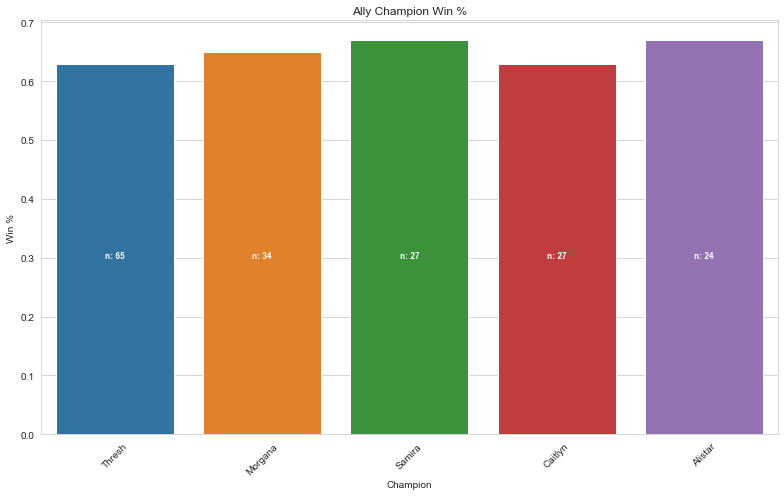

In [18]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize = (11,7))

ax = sns.barplot(x=df_win_prcnt.index, y= df_win_prcnt['Win %'], data=df_win_prcnt)
ax.set(xlabel='Champion', ylabel='Win %')  
ax.set_title('Ally Champion Win %')


nobs = df_win_prcnt["Games Played"].values
nobs = ["n: " + str(i) for i in nobs]

pos = range(len(nobs))
for tick,label in zip(pos, ax.get_xticklabels()):
    ax.text(pos[tick], 0.3, nobs[tick], horizontalalignment='center', size='small', color='w', weight='semibold')

plt.xticks(rotation=45) 

plt.tight_layout()

In [19]:
#win% against certain enemy champs
#threshold is below 40% wr and 20 or more games played with

win_prcnt_enemyChamps = {}
for champ in dict_loss_champ_counts_sorted_translated.keys():
    if dict_loss_champ_counts_sorted_translated[champ]/dict_enemyChamp_counts_sorted_translated[champ] < .4:
        if dict_enemyChamp_counts_sorted_translated[champ] >= 20:
            win_prcnt_enemyChamps[champ] = "{:.0%}".format(
                                    dict_loss_champ_counts_sorted_translated[champ]/
                                    dict_enemyChamp_counts_sorted_translated[champ]),\
                                    "Games played: {}".format(dict_enemyChamp_counts_sorted_translated[champ])
    else:
        continue

win_prcnt_enemyChamps

{'Sett': ('38%', 'Games played: 34'),
 'Yone': ('38%', 'Games played: 26'),
 'Galio': ('36%', 'Games played: 28'),
 'Caitlyn': ('38%', 'Games played: 26'),
 'Samira': ('34%', 'Games played: 29'),
 'Aatrox': ('36%', 'Games played: 25'),
 'Zed': ('33%', 'Games played: 24'),
 'Seraphine': ('35%', 'Games played: 23'),
 'Sivir': ('35%', 'Games played: 20'),
 'Fiora': ('35%', 'Games played: 20')}

In [20]:
#let's put this in a dataframe

df_win_prcnt_loss = pd.DataFrame(win_prcnt_enemyChamps).T

df_win_prcnt_loss.columns = ['Win %', 'Games Played']
df_win_prcnt_loss['Games Played'] = df_win_prcnt_loss['Games Played'].str[-2:]
df_win_prcnt_loss['Win %'] = df_win_prcnt_loss['Win %'].str[:-1].astype(int)/100

df_win_prcnt_loss

,Win %,Games Played
Sett,0.38,34
Yone,0.38,26
Galio,0.36,28
Caitlyn,0.38,26
Samira,0.34,29
Aatrox,0.36,25
Zed,0.33,24
Seraphine,0.35,23
Sivir,0.35,20
Fiora,0.35,20


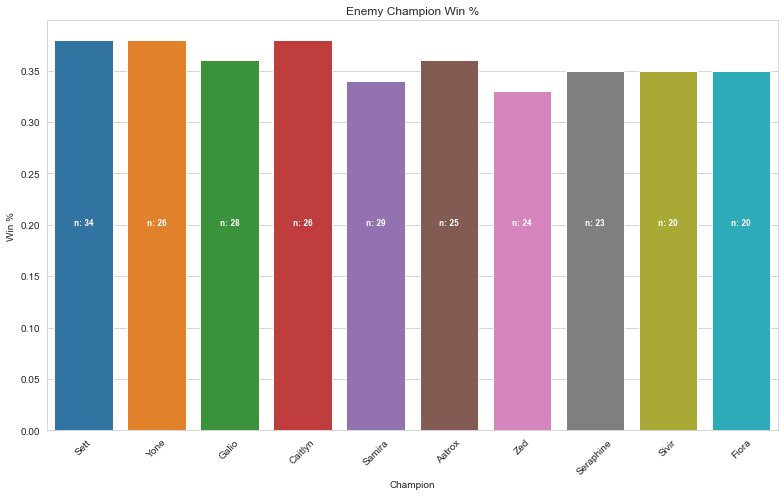

In [21]:
#now let's visualize this
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize = (11,7))

ax = sns.barplot(x=df_win_prcnt_loss.index, y= df_win_prcnt_loss['Win %'], data=df_win_prcnt_loss)
ax.set(xlabel='Champion', ylabel='Win %')  
ax.set_title('Enemy Champion Win %')


nobs = df_win_prcnt_loss["Games Played"].values
nobs = ["n: " + str(i) for i in nobs]

pos = range(len(nobs))
for tick,label in zip(pos, ax.get_xticklabels()):
    ax.text(pos[tick], 0.2, nobs[tick], horizontalalignment='center', size='small', color='w', weight='semibold')

plt.xticks(rotation=45) 

plt.tight_layout()

In [22]:
#of wins with certain players

dict_win_ally_counts = {}

for x in range(0,len(df_personal_data[df_personal_data['win'] == True]['allyTeam'].values)):
    for i in range (0,5):
        if df_personal_data[df_personal_data['win'] == True]['allyTeam'].values[x][i] in dict_win_ally_counts:
            dict_win_ally_counts[df_personal_data[df_personal_data['win'] == True]['allyTeam'].values[x][i]] += 1
        else:
            dict_win_ally_counts[df_personal_data[df_personal_data['win'] == True]['allyTeam'].values[x][i]] = 1

dict_win_ally_counts_sorted = {k: v for k, v in sorted(dict_win_ally_counts.items(), key=lambda item: item[1], reverse=True)}
dict_win_ally_counts_sorted

{'dTian': 261,
 'Leviˆ': 6,
 'San E': 3,
 'Gristlestick': 3,
 'WorstRegionWorld': 3,
 'Tiny Asian Boy': 3,
 'CREAMPIELIBERALS': 3,
 'Sharpeim': 2,
 'Sunshine GirI': 2,
 'Arfreezy': 2,
 'Stella2': 2,
 'Aoenstar': 2,
 'Stevens Pan': 2,
 'Mephistopheles': 2,
 'DanPLayz': 2,
 'MágicStick': 2,
 'Djo': 2,
 'B0ssTerence': 2,
 'Praxïs': 2,
 'King Brew': 2,
 'Prof Hex': 2,
 'Van Oofstendorp': 2,
 'Darko': 2,
 'lviiurt': 2,
 'Ultra25': 2,
 'Liquid Therapy ': 2,
 'iQT': 2,
 'DatAsianSmurf': 2,
 'snails on bikes': 2,
 'Abort Lulu Mains': 2,
 'MindfulChimp': 2,
 'Master IV': 2,
 'ISwearSheWsLvl18': 2,
 'nobaa': 2,
 'JMilkman': 2,
 'Bálsagna': 2,
 'the ëlephant': 2,
 'The Brown Sugar': 2,
 'inchesevan': 2,
 'llIllllIlllllllI': 2,
 'SlushPower': 2,
 'Tutorially': 2,
 'Tequila': 2,
 'Itto': 2,
 'Sleep everyday': 2,
 'I Did Hit Master': 2,
 'ﬁnd love': 2,
 'ggttlplp016': 2,
 'XiaoZuiMoLeMi': 2,
 'B1eCueWo': 2,
 'MU Senor': 2,
 'Beregond': 2,
 'HA PU': 2,
 'Wangadoodle': 2,
 'Meditation Gap': 2,
 'Aesth

In [23]:
#of losses with certain players

dict_loss_ally_counts = {}

for x in range(0,len(df_personal_data[df_personal_data['win'] == False]['allyTeam'].values)):
    for i in range (0,5):
        if df_personal_data[df_personal_data['win'] == False]['allyTeam'].values[x][i] in dict_loss_ally_counts:
            dict_loss_ally_counts[df_personal_data[df_personal_data['win'] == False]['allyTeam'].values[x][i]] += 1
        else:
            dict_loss_ally_counts[df_personal_data[df_personal_data['win'] == False]['allyTeam'].values[x][i]] = 1

            
dict_loss_ally_counts_sorted = {k: v for k, v in sorted(dict_loss_ally_counts.items(), key=lambda item: item[1], reverse=True)}
dict_loss_ally_counts_sorted

{'dTian': 239,
 'Claim': 3,
 'Shower or League': 3,
 'ZoIa': 3,
 'babtundae': 2,
 'uEwEmMarina': 2,
 'CitySushi33': 2,
 'IMKOREANADPLAYER': 2,
 'Zzzzzzzzed': 2,
 'I want study': 2,
 'SS TÈO BÁNH XÈO': 2,
 'Not Viable': 2,
 'Leviˆ': 2,
 'WAHWAH': 2,
 'DESTINY lSLAND': 2,
 'CloneEngi': 2,
 'Stafford': 2,
 'XxWarDoomxX': 2,
 'Kenpachí': 2,
 'Besaid': 2,
 'Professor Nugg': 2,
 ' Folklorique': 2,
 'mewblaster': 2,
 'Dare Me': 2,
 'Praxïs': 2,
 'Geranimo': 2,
 'Succulent Burger': 2,
 'Bushido Wolf': 2,
 'Cheekzr': 2,
 'DDOSS': 2,
 'Dîamond Rose': 2,
 'ADcürry': 2,
 'iHopeTheFaquDo': 2,
 'TheTarians': 2,
 'PHOENIX XXX': 2,
 'Spirit Blossom': 2,
 'upper moon two': 2,
 'LoLViirtue': 2,
 'Kizech': 2,
 'LVL 13 Gangplank': 2,
 'pawsubly': 2,
 'Jeƒf': 2,
 'yumichi': 2,
 'Kyree': 2,
 'Akitzu': 2,
 'blacknub3': 2,
 'baby mama': 2,
 '19 17 03 08': 2,
 'Sup im Carrier': 2,
 'HolyCarrot': 2,
 'Kan Davasi': 2,
 '1st Keklel': 2,
 'Reaperˆ': 2,
 'BT Soft Mist': 2,
 'She my qt ': 1,
 'Disdáin': 1,
 'STREETS

In [24]:
#of games with certain players

dict_ally_counts = {}

for x in range(0,len(df_personal_data['allyTeam'].values)):
    for i in range (0,5):
        if df_personal_data['allyTeam'].values[x][i] in dict_ally_counts:
            dict_ally_counts[df_personal_data['allyTeam'].values[x][i]] += 1
        else:
            dict_ally_counts[df_personal_data['allyTeam'].values[x][i]] = 1

dict_ally_counts_sorted = {k: v for k, v in sorted(dict_ally_counts.items(), key=lambda item: item[1], reverse=True)}
dict_ally_counts_sorted

{'dTian': 500,
 'Leviˆ': 8,
 'San E': 4,
 'Praxïs': 4,
 'Professor Nugg': 4,
 'Claim': 4,
 'pawsubly': 4,
 'ZoIa': 4,
 'Aoenstar': 3,
 'Gristlestick': 3,
 'Not Viable': 3,
 'MágicStick': 3,
 'Van Oofstendorp': 3,
 'XxWarDoomxX': 3,
 'Darko': 3,
 'Dare Me': 3,
 'Liquid Therapy ': 3,
 'Geranimo': 3,
 'Succulent Burger': 3,
 'WorstRegionWorld': 3,
 'Cheekzr': 3,
 'DDOSS': 3,
 'nobaa': 3,
 'Tiny Asian Boy': 3,
 'LoLViirtue': 3,
 'SlushPower': 3,
 'the ëlephant': 3,
 'Shower or League': 3,
 'CREAMPIELIBERALS': 3,
 'XiaoZuiMoLeMi': 3,
 'Sup im Carrier': 3,
 'ROCKER OF WORLDS': 3,
 'SummonerSquid': 2,
 'babtundae': 2,
 'uEwEmMarina': 2,
 'ytsaid': 2,
 'Esteben': 2,
 'Markvoops': 2,
 'Sharpeim': 2,
 'Sunshine GirI': 2,
 'bigfr0st2': 2,
 'Arfreezy': 2,
 'Stella2': 2,
 'ScaledBy25Min': 2,
 'CitySushi33': 2,
 'IMKOREANADPLAYER': 2,
 'Stevens Pan': 2,
 'Remained': 2,
 'SpaciaI': 2,
 'Zzzzzzzzed': 2,
 'I want study': 2,
 'Mephistopheles': 2,
 'DJdragBee': 2,
 'abadpIayer': 2,
 'LTQ Kwan': 2,
 'SS T

In [25]:
#summoners analysis - which PLAYERS (not champions) do I play well/poorly with?

dict_winners = {}

for name in dict_ally_counts_sorted.keys():
    if dict_ally_counts_sorted[name] >= 3:
        if name in dict_win_ally_counts_sorted.keys():
            try:
                dict_winners[name] = "{:.0%}".format(dict_win_ally_counts_sorted[name]/dict_ally_counts_sorted[name]),\
                'Games played: {}'.format(dict_ally_counts_sorted[name])
            except:
                continue
        else:
            try: 
                dict_winners[name] = "{:.0%}".format(0/dict_ally_counts_sorted[name]),\
                'Games played: {}'.format(dict_ally_counts_sorted[name])
            except:
                continue
    elif dict_ally_counts_sorted[name] == 2:
        if name not in dict_win_ally_counts_sorted:
            try:
                dict_winners[name] = "{:.0%}".format(0),\
                'Games played: {}'.format(dict_ally_counts_sorted[name])
            except:
                continue
    else:
        continue
    
dict_winners

{'dTian': ('52%', 'Games played: 500'),
 'Leviˆ': ('75%', 'Games played: 8'),
 'San E': ('75%', 'Games played: 4'),
 'Praxïs': ('50%', 'Games played: 4'),
 'Professor Nugg': ('50%', 'Games played: 4'),
 'Claim': ('25%', 'Games played: 4'),
 'pawsubly': ('50%', 'Games played: 4'),
 'ZoIa': ('25%', 'Games played: 4'),
 'Aoenstar': ('67%', 'Games played: 3'),
 'Gristlestick': ('100%', 'Games played: 3'),
 'Not Viable': ('33%', 'Games played: 3'),
 'MágicStick': ('67%', 'Games played: 3'),
 'Van Oofstendorp': ('67%', 'Games played: 3'),
 'XxWarDoomxX': ('33%', 'Games played: 3'),
 'Darko': ('67%', 'Games played: 3'),
 'Dare Me': ('33%', 'Games played: 3'),
 'Liquid Therapy ': ('67%', 'Games played: 3'),
 'Geranimo': ('33%', 'Games played: 3'),
 'Succulent Burger': ('33%', 'Games played: 3'),
 'WorstRegionWorld': ('100%', 'Games played: 3'),
 'Cheekzr': ('33%', 'Games played: 3'),
 'DDOSS': ('33%', 'Games played: 3'),
 'nobaa': ('67%', 'Games played: 3'),
 'Tiny Asian Boy': ('100%', 'Games 

In [26]:
#summoners analysis - which PLAYERS (not champions) have I never won a game with?

dict_winners = {}

for name in dict_ally_counts_sorted.keys():
    if dict_ally_counts_sorted[name] > 1:
        if name in dict_win_ally_counts_sorted.keys():
            continue
        else:
            try: 
                dict_winners[name] = "{:.0%}".format(0/dict_ally_counts_sorted[name]),\
                'Games played: {}'.format(dict_ally_counts_sorted[name])
            except:
                continue
    
dict_winners

{'Shower or League': ('0%', 'Games played: 3'),
 'babtundae': ('0%', 'Games played: 2'),
 'uEwEmMarina': ('0%', 'Games played: 2'),
 'CitySushi33': ('0%', 'Games played: 2'),
 'IMKOREANADPLAYER': ('0%', 'Games played: 2'),
 'Zzzzzzzzed': ('0%', 'Games played: 2'),
 'I want study': ('0%', 'Games played: 2'),
 'SS TÈO BÁNH XÈO': ('0%', 'Games played: 2'),
 'WAHWAH': ('0%', 'Games played: 2'),
 'DESTINY lSLAND': ('0%', 'Games played: 2'),
 'CloneEngi': ('0%', 'Games played: 2'),
 'Stafford': ('0%', 'Games played: 2'),
 'Kenpachí': ('0%', 'Games played: 2'),
 'Besaid': ('0%', 'Games played: 2'),
 ' Folklorique': ('0%', 'Games played: 2'),
 'mewblaster': ('0%', 'Games played: 2'),
 'Bushido Wolf': ('0%', 'Games played: 2'),
 'Dîamond Rose': ('0%', 'Games played: 2'),
 'ADcürry': ('0%', 'Games played: 2'),
 'iHopeTheFaquDo': ('0%', 'Games played: 2'),
 'TheTarians': ('0%', 'Games played: 2'),
 'PHOENIX XXX': ('0%', 'Games played: 2'),
 'Spirit Blossom': ('0%', 'Games played: 2'),
 'upper moo

In [27]:
#null - there is no difference in damage dealt to champions in wins vs losses
#alternative - there is a difference in damage dealt to champions in wins vs losses

df_damage_dealt_win = df_personal_data[df_personal_data['win'] == True]
df_damage_dealt_loss = df_personal_data[df_personal_data['win'] == False]

display(stats.ttest_ind(df_damage_dealt_win.totalDamageDealtToChampions,df_damage_dealt_loss.totalDamageDealtToChampions))

display(df_damage_dealt_win['totalDamageDealtToChampions'].median(), df_damage_dealt_loss['totalDamageDealtToChampions'].median())

#reject null. There is a difference in damage dealt to champions in wins vs losses

Ttest_indResult(statistic=3.867882576009121, pvalue=0.0001243565743010828)

15628.0

12342.0

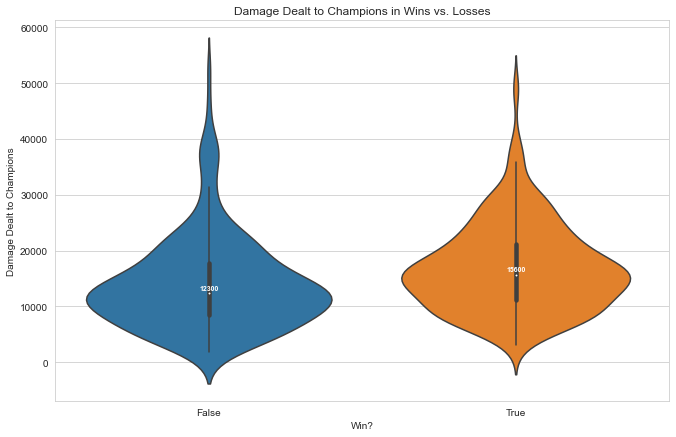

In [28]:
fig, ax = plt.subplots(figsize = (11,7))

ax = sns.violinplot(data = df_personal_data, x='win', y='totalDamageDealtToChampions')

medians = df_personal_data.groupby(['win'])['totalDamageDealtToChampions'].median().values.round(-2).astype(int)
vertical_offset = df_personal_data['totalDamageDealtToChampions'].median() * 0.05 # offset from median for display

for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

ax.set_title('Damage Dealt to Champions in Wins vs. Losses')
ax.set_ylabel('Damage Dealt to Champions')
ax.set_xlabel('Win?');


In [29]:
#null - there is no difference in champion level in wins vs losses
#alternative - there is a difference in champion level in wins vs losses

df_champion_level_win = df_personal_data[df_personal_data['win'] == True]['champLevel']
df_champion_level_loss = df_personal_data[df_personal_data['win'] == False]['champLevel']

display(stats.ttest_ind(df_champion_level_win,df_champion_level_loss))

display(df_champion_level_win.mean(), df_champion_level_loss.mean())

#reject null. There is a difference in champion level in wins vs losses

Ttest_indResult(statistic=6.332430839959875, pvalue=5.395902869351783e-10)

15.245210727969349

14.01673640167364

In [30]:
#null - there is no difference in longest time spent living in wins vs losses
#alternative - there is a difference in longest time spent living in wins vs losses

df_longest_time_alive_win = df_personal_data[df_personal_data['win'] == True]['longestTimeSpentLiving']
df_longest_time_alive_loss = df_personal_data[df_personal_data['win'] == False]['longestTimeSpentLiving']

display(stats.ttest_ind(df_longest_time_alive_win,df_longest_time_alive_loss))

display(df_longest_time_alive_win.mean(), df_longest_time_alive_loss.mean())

#seems fishy

Ttest_indResult(statistic=0.8733091443889192, pvalue=0.38291549954934845)

598.7624521072797

576.9246861924686

In [31]:
#must drop 0s (aka - a perfect game)

df_longest_time_alive_win = df_longest_time_alive_win[df_personal_data[df_personal_data['win'] == True]
                                                      ['longestTimeSpentLiving'] > 0]
df_longest_time_alive_loss = df_longest_time_alive_loss[df_personal_data[df_personal_data['win'] == False]
                                                        ['longestTimeSpentLiving'] > 0]

display(stats.ttest_ind(df_longest_time_alive_win,df_longest_time_alive_loss))

display(df_longest_time_alive_win.mean(), df_longest_time_alive_loss.mean())

#fail to reject null. There is no difference in longest time spent living in wins vs losses
#however, this doesn't account for perfect games

Ttest_indResult(statistic=2.2195373539530765, pvalue=0.026911987866948074)

630.1491935483871

576.9246861924686

In [32]:
#null - there is no difference in vision wards bought in wins vs losses
#alternative - there is a difference in vision wards bought in wins vs losses

df_vision_wards_bought_win = df_personal_data[df_personal_data['win'] == True]['visionWardsBoughtInGame']
df_vision_wards_bought_loss = df_personal_data[df_personal_data['win'] == False]['visionWardsBoughtInGame']

display(stats.ttest_ind(df_vision_wards_bought_win,df_vision_wards_bought_loss))

display(df_vision_wards_bought_win.mean(), df_vision_wards_bought_loss.mean())

#reject null. There is a difference in vision wards bought in wins vs losses

Ttest_indResult(statistic=3.9367879426158203, pvalue=9.433893061436219e-05)

2.0114942528735633

1.5564853556485356

In [33]:
#null - there is no difference in game length between wins vs losses
#alternative - there is a difference in game length between wins vs losses

df_game_length_win = df_personal_data[df_personal_data['win'] == True]['gameDuration']
df_game_length_loss = df_personal_data[df_personal_data['win'] == False]['gameDuration']

display(stats.ttest_ind(df_game_length_win,df_game_length_loss))

display(df_game_length_win.median()/60, df_game_length_loss.median()/60)

#fail to reject null. There isn't a difference in game length between wins and losses

Ttest_indResult(statistic=0.2512372125402861, pvalue=0.8017343480857206)

26.616666666666667

27.033333333333335

In [34]:
df_personal_data['gameDurationMin'] = df_personal_data['gameDuration']/60

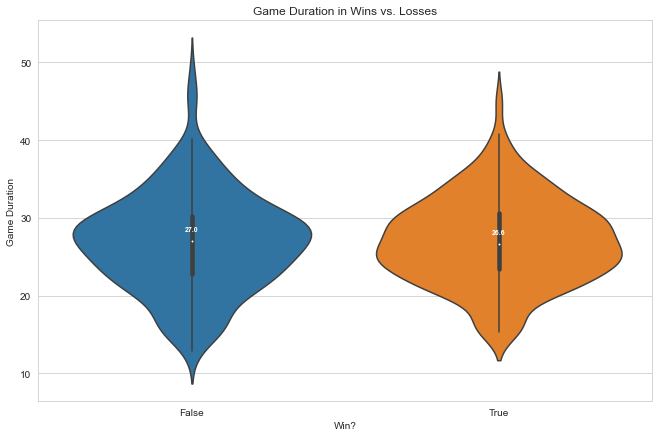

In [35]:
fig, ax = plt.subplots(figsize = (11,7))

ax = sns.violinplot(data = df_personal_data, x='win', y='gameDurationMin')

medians = df_personal_data.groupby(['win'])['gameDurationMin'].median().values.round(1)
vertical_offset = df_personal_data['gameDurationMin'].median() * 0.05 # offset from median for display

for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

ax.set_title('Game Duration in Wins vs. Losses')
ax.set_ylabel('Game Duration')
ax.set_xlabel('Win?');


In [36]:
#null - there is no difference between cs per 10 for wins v losses
#alternative - there is a difference between cs per 10 for wins v losses

df_csMin_win = df_personal_data[df_personal_data['win'] == True]['csPerMin'].dropna()
df_csMin_loss = df_personal_data[df_personal_data['win'] == False]['csPerMin'].dropna()

display(stats.ttest_ind(df_csMin_win,df_csMin_loss))

display(df_csMin_win.median(), df_csMin_loss.median())

Ttest_indResult(statistic=3.3802238270703917, pvalue=0.0007811507316360758)

6.6856168277430355

6.461001164144354

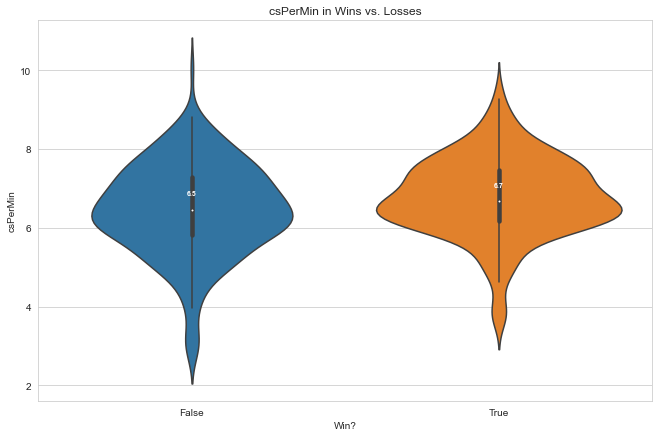

In [37]:
fig, ax = plt.subplots(figsize = (11,7))

ax = sns.violinplot(data = df_personal_data, x='win', y='csPerMin')

medians = df_personal_data.groupby(['win'])['csPerMin'].median().values.round(1)
vertical_offset = df_personal_data['csPerMin'].median() * 0.05 # offset from median for display

for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

ax.set_title('csPerMin in Wins vs. Losses')
ax.set_ylabel('csPerMin')
ax.set_xlabel('Win?');

In [38]:
#null - there is no difference between cs per 10 in the first 10 minutes of the game for wins v losses
#alternative - there is a difference between cs per 10 in the first 10 minutes of the game for wins v losses

df_cs10_win_first10 = df_personal_data[df_personal_data['win'] == True]['creepsPerMinDeltas 0-10'].dropna()
df_cs10_loss_first10 = df_personal_data[df_personal_data['win'] == False]['creepsPerMinDeltas 0-10'].dropna()

display(stats.ttest_ind(df_cs10_win_first10,df_cs10_loss_first10))

display(df_cs10_win_first10.mean(), df_cs10_loss_first10.mean())

Ttest_indResult(statistic=2.9315781161761616, pvalue=0.0035275432690452884)

6.314176245210728

6.002092050209205

In [39]:
#null - there is no difference between cs per 10 in the second 10 minutes of the game for wins v losses
#alternative - there is a difference between cs per 10 in the second 10 minutes of the game for wins v losses

df_cs10_win_second10 = df_personal_data[df_personal_data['win'] == True]['creepsPerMinDeltas 10-20'].dropna()
df_cs10_loss_second10 = df_personal_data[df_personal_data['win'] == False]['creepsPerMinDeltas 10-20'].dropna()

display(stats.ttest_ind(df_cs10_win_second10,df_cs10_loss_second10))

display(df_cs10_win_second10.mean(), df_cs10_loss_second10.mean())

Ttest_indResult(statistic=2.2130383394079445, pvalue=0.027398320298730558)

7.532365145228215

7.235406698564594

In [40]:
#null - there is no difference between cs per 10 in the third 10 minutes of the game for wins v losses
#alternative - there is a difference between cs per 10 in the third 10 minutes of the game for wins v losses

df_cs10_win_third10 = df_personal_data[df_personal_data['win'] == True]['creepsPerMinDeltas 20-30'].dropna()
df_cs10_loss_third10 = df_personal_data[df_personal_data['win'] == False]['creepsPerMinDeltas 20-30'].dropna()

display(stats.ttest_ind(df_cs10_win_third10,df_cs10_loss_third10))

display(df_cs10_win_third10.mean(), df_cs10_loss_third10.mean())

Ttest_indResult(statistic=-1.36160820415717, pvalue=0.1755896121934413)

6.093243243243243

6.519047619047618

In [41]:
#null - there is no difference between damage taken during the first 10 minutes of the game for wins v losses
#alternative - there is a difference between damage taken during the first 10 minutes of the game for wins v losses

df_damage_taken_first10_win = df_personal_data[df_personal_data['win'] == True]['damageTakenPerMinDeltas 0-10'].dropna()
df_damage_taken_first10_loss = df_personal_data[df_personal_data['win'] == False]['damageTakenPerMinDeltas 0-10'].dropna()

display(stats.ttest_ind(df_damage_taken_first10_win,df_damage_taken_first10_loss))

display(df_damage_taken_first10_win.mean(), df_damage_taken_first10_loss.mean())

Ttest_indResult(statistic=-3.0111819986651644, pvalue=0.002734504518983182)

364.03563218390804

397.76359832635984

In [42]:
#null - there is no difference between damage taken during the second 10 minutes of the game for wins v losses
#alternative - there is a difference between damage taken during the second 10 minutes of the game for wins v losses

df_damage_taken_second10_win = df_personal_data[df_personal_data['win'] == True]['damageTakenPerMinDeltas 10-20'].dropna()
df_damage_taken_second10_loss = df_personal_data[df_personal_data['win'] == False]['damageTakenPerMinDeltas 10-20'].dropna()

display(stats.ttest_ind(df_damage_taken_second10_win,df_damage_taken_second10_loss))

display(df_damage_taken_second10_win.mean(), df_damage_taken_second10_loss.mean())

Ttest_indResult(statistic=-2.486456417732453, pvalue=0.013265503856401129)

652.895020746888

694.1904306220096

In [43]:
#null - there is no difference between damage taken during the third 10 minutes of the game for wins v losses
#alternative - there is a difference between damage taken during the third 10 minutes of the game for wins v losses

df_damage_taken_third10_win = df_personal_data[df_personal_data['win'] == True]['damageTakenPerMinDeltas 20-30'].dropna()
df_damage_taken_third10_loss = df_personal_data[df_personal_data['win'] == False]['damageTakenPerMinDeltas 20-30'].dropna()

display(stats.ttest_ind(df_damage_taken_third10_win,df_damage_taken_third10_loss))

display(df_damage_taken_third10_win.mean(), df_damage_taken_third10_loss.mean())

Ttest_indResult(statistic=-2.646468273699465, pvalue=0.009100335495990108)

827.1027027027028

947.1634920634921

In [45]:
#100 = blue
#200 = red

total_games = len(df_personal_data)
actual_win_perc = len(df_personal_data[df_personal_data['win'] == True])/total_games

blue_games = len(df_personal_data[df_personal_data['teamColor'] == 100])
red_games = len(df_personal_data[df_personal_data['teamColor'] == 200])

blue_games_won = len(df_personal_data[(df_personal_data['teamColor'] == 100) & 
                                  (df_personal_data['win'] == True)]['champion'])
red_games_won = len(df_personal_data[(df_personal_data['teamColor'] == 200) & 
                                  (df_personal_data['win'] == True)]['champion'])

display("Red side win %: {:.0%}".format(red_games_won/red_games))
display("Blue side win %: {:.0%}".format(blue_games_won/blue_games))

expected = [red_games*actual_win_perc, blue_games*actual_win_perc]
observed = [red_games_won, blue_games_won]

# display(expected, observed)

#it looks like i'm stronger on the red side than blue side. but is this by random chance, since we're just looking at a 
#500 game sample? There's some probability of getting this result, even if the null hypothesis is true.

#null - equal win % between red and blue side
#alternative - not equal win % between red and blue side

stats.chisquare(f_obs=observed, f_exp=expected)

#accept null: I have an equal win % between red and blue

'Red side win %: 49%'

'Blue side win %: 55%'

Power_divergenceResult(statistic=0.7652957351529124, pvalue=0.38167630016868637)

# Modeling

Can I create a model that will predict whether or not I won a game?

In order to evaluate our model, let's create a class to help organize our model and cross validation.

In [46]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=5):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 5)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

Before diving into a logistic regression, let's finalize the data we want to analyze.

In [47]:
#reminder of our dataframe
df_personal_data

,champion,gameDuration,win,totalDamageDealtToChampions,goldEarned,champLevel,totalMinionsKilled,longestTimeSpentLiving,teamColor,visionWardsBoughtInGame,...,damageTakenPerMinDeltas 10-20,damageTakenPerMinDeltas 20-30,creepsPerMinDeltas 10-20,creepsPerMinDeltas 20-30,allyTeam,allyChamps,enemyTeam,enemyChamps,csPerMin,gameDurationMin
0,10,912,False,5630,4391,8,43,225,200,1,...,NaN,NaN,NaN,NaN,"[She my qt , dTian, Disdáin, STREETS ON FIRE, ...","[360, 10, 246, 131, 147]","[Big Zu, pandabear pants, Pellicle, Urpog, Scr...","[67, 164, 120, 6, 16]",2.828947,15.200000
1,10,1542,False,7710,8385,13,163,567,200,2,...,800.2,NaN,5.8,NaN,"[Big Zu, victorlzz1997, valksoar, Lanzar, dTian]","[15, 412, 55, 131, 10]","[Jungledog1, Ad Mids, we boolin xd, Muffinhawk...","[115, 157, 126, 104, 43]",6.342412,25.700000
2,10,1532,False,8700,8007,13,120,351,200,0,...,562.3,NaN,5.0,NaN,"[gebble is taken, objechtion, dTian, FERV0R, M...","[234, 40, 10, 90, 523]","[Almarea, Moeithy, ˇEli, Liquid Therapy , vic...","[119, 112, 5, 25, 58]",4.699739,25.533333
3,10,1597,True,17426,11607,15,164,448,200,1,...,908.6,NaN,7.4,NaN,"[PharmDRPh, Don Scuttersmith, G00BIE, dTian, w...","[117, 145, 103, 10, 5]","[InfamousDMT, Stácy, Areeb, Phalus, Sillody]","[238, 64, 517, 555, 202]",6.161553,26.616667
4,10,1769,True,22599,14735,16,206,906,100,1,...,577.8,NaN,9.6,NaN,"[CR Bbi dol ie, GoodNight Bubble, LEEESHINN, d...","[39, 876, 53, 10, 81]","[Skarrom, smiit, Professor Nugg, The Sage, Siz...","[154, 55, 555, 145, 64]",6.986998,29.483333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,10,1992,True,15306,13966,17,207,665,200,4,...,936.1,1084.2,8.9,3.6,"[dTian, TAIJI Orca, EyeSeeM, Professor Nugg, X...","[10, 105, 121, 555, 145]","[Miskas Phab Ej, xSprintx, Jeanne, Kastelhn, C...","[44, 54, 222, 421, 61]",6.234940,33.200000
496,10,1469,True,7992,10740,15,197,679,100,4,...,666.6,NaN,8.2,NaN,"[kat valentíne, TTV geomener900, dTian, Turska...","[55, 107, 10, 147, 18]","[Gochu XL, My captain, XeoChing, Foo Fighters,...","[421, 117, 222, 246, 12]",8.046290,24.483333
497,10,1423,False,11137,8228,14,193,692,200,1,...,742.7,NaN,10.0,NaN,"[collectingsalt, Eepblob, dTian, Bowkeeper, Dî...","[45, 51, 10, 120, 53]","[Little Katido, Sup im Carrier, girl destroyer...","[9, 25, 22, 68, 234]",8.137737,23.716667
498,10,1263,True,18435,11701,13,158,821,100,2,...,736.8,NaN,7.6,NaN,"[dTian, Lionel messione, Sup im Carrier, leagu...","[10, 120, 147, 498, 3]","[sAvîOr, CheckYourCorners, Hodgie, KSPIRITO, B...","[238, 427, 412, 222, 86]",7.505938,21.050000


In [48]:
#preview dataframe for nulls/NAs
df_personal_data.isna().sum()

champion                           0
gameDuration                       0
win                                0
totalDamageDealtToChampions        0
goldEarned                         0
champLevel                         0
totalMinionsKilled                 0
longestTimeSpentLiving             0
teamColor                          0
visionWardsBoughtInGame            0
firstBloodKill                     0
firstBloodAssist                   0
damageTakenPerMinDeltas 0-10       0
creepsPerMinDeltas 0-10            0
damageTakenPerMinDeltas 10-20     50
damageTakenPerMinDeltas 20-30    363
creepsPerMinDeltas 10-20          50
creepsPerMinDeltas 20-30         363
allyTeam                           0
allyChamps                         0
enemyTeam                          0
enemyChamps                        0
csPerMin                           0
gameDurationMin                    0
dtype: int64

In [49]:
#variables of interest
variables_for_log_reg = ['gameDuration', 'totalDamageDealtToChampions', 'goldEarned', 'champLevel', 'longestTimeSpentLiving', 
               'teamColor', 'visionWardsBoughtInGame', 'firstBloodKill', 'csPerMin', 'win']
df_log_reg = df_personal_data[variables_for_log_reg]

#remove NAs from firstBloodKill - only 1 record, so fine dropping
df_log_reg = df_log_reg.dropna()
df_log_reg

,gameDuration,totalDamageDealtToChampions,goldEarned,champLevel,longestTimeSpentLiving,teamColor,visionWardsBoughtInGame,firstBloodKill,csPerMin,win
0,912,5630,4391,8,225,200,1,False,2.828947,False
1,1542,7710,8385,13,567,200,2,True,6.342412,False
2,1532,8700,8007,13,351,200,0,False,4.699739,False
3,1597,17426,11607,15,448,200,1,True,6.161553,True
4,1769,22599,14735,16,906,100,1,False,6.986998,True
...,...,...,...,...,...,...,...,...,...,...
495,1992,15306,13966,17,665,200,4,False,6.234940,True
496,1469,7992,10740,15,679,100,4,False,8.046290,True
497,1423,11137,8228,14,692,200,1,False,8.137737,False
498,1263,18435,11701,13,821,100,2,False,7.505938,True


In [50]:
# Convert True/False, 100/200
df_log_reg['firstBloodKill'] = np.where(df_log_reg['firstBloodKill'] == True, 1, 0)
df_log_reg['teamColor_isBlue'] = np.where(df_log_reg['teamColor'] == 100, 1, 0)

#final dataframe for regression
df_log_reg

,gameDuration,totalDamageDealtToChampions,goldEarned,champLevel,longestTimeSpentLiving,teamColor,visionWardsBoughtInGame,firstBloodKill,csPerMin,win,teamColor_isBlue
0,912,5630,4391,8,225,200,1,0,2.828947,False,0
1,1542,7710,8385,13,567,200,2,1,6.342412,False,0
2,1532,8700,8007,13,351,200,0,0,4.699739,False,0
3,1597,17426,11607,15,448,200,1,1,6.161553,True,0
4,1769,22599,14735,16,906,100,1,0,6.986998,True,1
...,...,...,...,...,...,...,...,...,...,...,...
495,1992,15306,13966,17,665,200,4,0,6.234940,True,0
496,1469,7992,10740,15,679,100,4,0,8.046290,True,1
497,1423,11137,8228,14,692,200,1,0,8.137737,False,0
498,1263,18435,11701,13,821,100,2,0,7.505938,True,1


In [51]:
x_variables = ['gameDuration', 'totalDamageDealtToChampions', 'goldEarned', 'champLevel', 'longestTimeSpentLiving', 
               'teamColor_isBlue', 'visionWardsBoughtInGame', 'firstBloodKill', 'csPerMin']

X = df_log_reg[x_variables]
y = df_log_reg['win']

### Model 1 - Baseline

Our baseline model will be a model which will always choose the majority class (a win).

In [52]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=77)

baseline_model = DummyClassifier(strategy="most_frequent")

baseline_model.fit(X_train, y_train)

baseline_model.predict(X_train)

cv_results = cross_val_score(baseline_model, X_train, y_train, cv=5)
cv_results

array([0.53333333, 0.53333333, 0.54666667, 0.54666667, 0.54666667])

In [53]:
baseline_model_results = ModelWithCV(
                        model=baseline_model,
                        model_name='Baseline',
                        X=X_train, 
                        y=y_train
)

CV Results for `Baseline` model:
            0.54133 ± 0.00653 accuracy
        


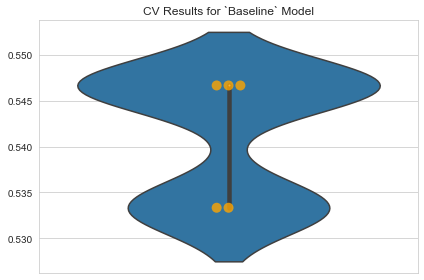

In [54]:
fig, ax = plt.subplots()

ax = baseline_model_results.plot_cv(ax)
plt.tight_layout();

baseline_model_results.print_cv_summary()

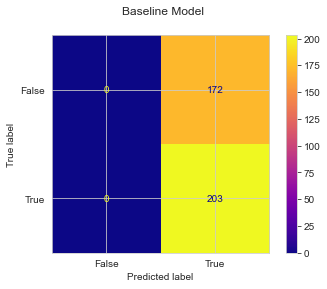

In [55]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots()

fig.suptitle("Baseline Model")

plot_confusion_matrix(baseline_model, X_train, y_train, ax=ax, cmap="plasma");

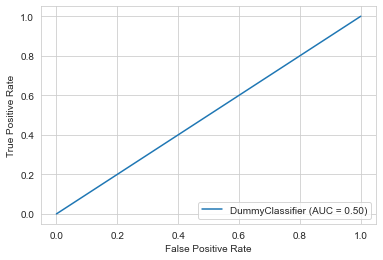

In [56]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(baseline_model,X_train,y_train)

OK - a pretty bad model, as expected. We'd hope that future iterations will improve, with the ROC curve shifting up and predictions being higher than 55.6%.

### Model 2

Let's normalize our data.

In [57]:
from sklearn.preprocessing import normalize
X_norm = normalize(X)
X_norm

array([[1.26641967e-01, 7.81791969e-01, 6.09742191e-01, ...,
        1.38861806e-04, 0.00000000e+00, 3.92832741e-04],
       [1.33984776e-01, 6.69923879e-01, 7.28574803e-01, ...,
        1.73780513e-04, 8.68902567e-05, 5.51093846e-04],
       [1.28439420e-01, 7.29388353e-01, 6.71288798e-01, ...,
        0.00000000e+00, 0.00000000e+00, 3.94015497e-04],
       ...,
       [1.02103148e-01, 7.99102431e-01, 5.90375757e-01, ...,
        7.17520366e-05, 0.00000000e+00, 5.83899215e-04],
       [5.77060114e-02, 8.42288457e-01, 5.34614442e-01, ...,
        9.13792739e-05, 0.00000000e+00, 3.42943593e-04],
       [1.16615765e-01, 7.22677259e-01, 6.80116761e-01, ...,
        9.45788848e-05, 0.00000000e+00, 5.56887838e-04]])

In [58]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, random_state=77)

#no regularization for now
my_model = LogisticRegression(random_state = 77, penalty='none', max_iter=1000)

my_model.fit(X_train, y_train)
my_model.predict(X_train)

my_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, penalty='none', random_state=77)

In [59]:
my_model_results = ModelWithCV(
                        model=my_model,
                        model_name='Model 2',
                        X=X_train, 
                        y=y_train
)

CV Results for `Model 2` model:
            0.77333 ± 0.04462 accuracy
        


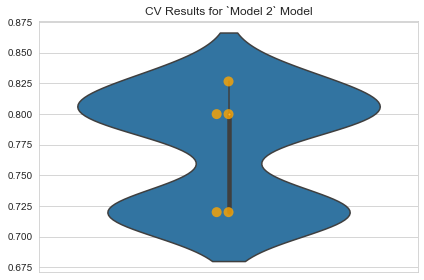

In [60]:
# Saving variable for convenience
model_results = my_model_results

# Plot CV results
fig, ax = plt.subplots()
ax = model_results.plot_cv(ax)
plt.tight_layout();
# Print CV results
model_results.print_cv_summary()

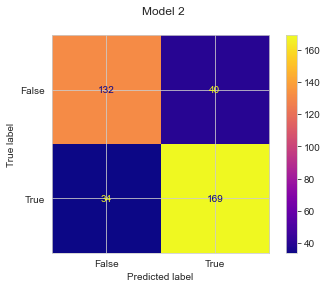

In [61]:
fig, ax = plt.subplots()

fig.suptitle("Model 2")

plot_confusion_matrix(my_model, X_train, y_train, ax=ax, cmap="plasma");

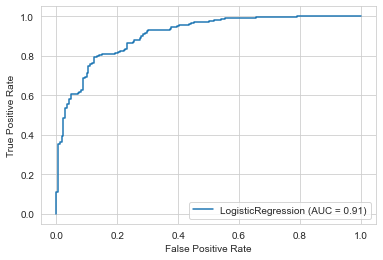

In [62]:
plot_roc_curve(my_model,X_train,y_train)

81% accuracy - a strong improvement.

In [63]:
# Let's get predictions for training & testing sets
y_hat_train = my_model.predict(X_train)
y_hat_test = my_model.predict(X_test)


# Was our model correct?
residuals = y_train == y_hat_train

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

print('\n','-'*30,'\n')

print('Percentage of values correctly predicted: ')
print(pd.Series(residuals).value_counts(normalize=True))

Number of values correctly predicted:
True     301
False     74
Name: win, dtype: int64

 ------------------------------ 

Percentage of values correctly predicted: 
True     0.802667
False    0.197333
Name: win, dtype: float64


In [64]:
#test set
residuals = y_test == y_hat_test

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

print('\n','-'*30,'\n')

print('Percentage of values correctly predicted: ')
print(pd.Series(residuals).value_counts(normalize=True))

Number of values correctly predicted:
True     107
False     18
Name: win, dtype: int64

 ------------------------------ 

Percentage of values correctly predicted: 
True     0.856
False    0.144
Name: win, dtype: float64


### Model 3

But could it be better? Let's try some poly features.

In [65]:
X
X_norm_df = pd.DataFrame(X_norm, columns = ['gameDuration', 'totalDamageDealtToChampions', 'goldEarned', 'champLevel', 'longestTimeSpentLiving', 'teamColor_isBlue', 'visionWardsBoughtInGame', 'firstBloodKill', 'csPerMin'])
X_norm_df

,gameDuration,totalDamageDealtToChampions,goldEarned,champLevel,longestTimeSpentLiving,teamColor_isBlue,visionWardsBoughtInGame,firstBloodKill,csPerMin
0,0.126642,0.781792,0.609742,0.001111,0.031244,0.000000,0.000139,0.000000,0.000393
1,0.133985,0.669924,0.728575,0.001130,0.049267,0.000000,0.000174,0.000087,0.000551
2,0.128439,0.729388,0.671289,0.001090,0.029427,0.000000,0.000000,0.000000,0.000394
3,0.076036,0.829678,0.552627,0.000714,0.021330,0.000000,0.000048,0.000048,0.000293
4,0.065394,0.835405,0.544701,0.000591,0.033492,0.000037,0.000037,0.000000,0.000258
...,...,...,...,...,...,...,...,...,...
495,0.095648,0.734937,0.670595,0.000816,0.031931,0.000000,0.000192,0.000000,0.000299
496,0.108938,0.592669,0.796454,0.001112,0.050353,0.000074,0.000297,0.000000,0.000597
497,0.102103,0.799102,0.590376,0.001005,0.049652,0.000000,0.000072,0.000000,0.000584
498,0.057706,0.842288,0.534614,0.000594,0.037511,0.000046,0.000091,0.000000,0.000343


In [66]:
from sklearn.preprocessing import PolynomialFeatures

x_variables = ['gameDuration', 'totalDamageDealtToChampions', 'goldEarned', 'champLevel', 'longestTimeSpentLiving', 
               'teamColor_isBlue', 'visionWardsBoughtInGame', 'firstBloodKill', 'csPerMin']

X = df_log_reg[x_variables]
y = df_log_reg['win']

X_train, X_test, y_train, y_test = train_test_split(X_norm_df, y, random_state=0)

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly_train = pd.DataFrame(poly.fit_transform(X_train), columns=poly.get_feature_names(X_train.columns))
X_poly_test = pd.DataFrame(poly.transform(X_test), columns=poly.get_feature_names(X_test.columns))
X_poly = pd.concat([X_poly_train, X_poly_test])
X_poly

,gameDuration,totalDamageDealtToChampions,goldEarned,champLevel,longestTimeSpentLiving,teamColor_isBlue,visionWardsBoughtInGame,firstBloodKill,csPerMin,gameDuration^2,...,teamColor_isBlue^2,teamColor_isBlue visionWardsBoughtInGame,teamColor_isBlue firstBloodKill,teamColor_isBlue csPerMin,visionWardsBoughtInGame^2,visionWardsBoughtInGame firstBloodKill,visionWardsBoughtInGame csPerMin,firstBloodKill^2,firstBloodKill csPerMin,csPerMin^2
0,0.074461,0.688184,0.717896,0.000827,0.074048,0.000000,0.000052,0.000000,0.000441,0.005544,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.670121e-09,0.000000e+00,2.279146e-08,0.000000e+00,0.000000e+00,1.945419e-07
1,0.112822,0.756859,0.643334,0.001016,0.023596,0.000078,0.000078,0.000000,0.000474,0.012729,...,6.104511e-09,6.104511e-09,0.000000e+00,3.703291e-08,6.104511e-09,0.000000e+00,3.703291e-08,0.000000e+00,0.000000e+00,2.246595e-07
2,0.092392,0.735240,0.667880,0.000831,0.069437,0.000000,0.000052,0.000000,0.000387,0.008536,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.697214e-09,0.000000e+00,2.010402e-08,0.000000e+00,0.000000e+00,1.498478e-07
3,0.106356,0.635012,0.763590,0.001041,0.048756,0.000000,0.000149,0.000074,0.000542,0.011312,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.209537e-08,1.104769e-08,8.059948e-08,5.523844e-09,4.029974e-08,2.940107e-07
4,0.068417,0.781253,0.620105,0.000739,0.020790,0.000000,0.000130,0.000000,0.000385,0.004681,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.702615e-08,0.000000e+00,5.022335e-08,0.000000e+00,0.000000e+00,1.481477e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,0.120401,0.585376,0.799941,0.001170,0.054143,0.000000,0.000000,0.000000,0.000584,0.014496,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.416035e-07
121,0.073732,0.865246,0.495405,0.000495,0.022037,0.000028,0.000083,0.000000,0.000202,0.005436,...,7.568997e-10,2.270699e-09,0.000000e+00,5.558129e-09,6.812098e-09,0.000000e+00,1.667439e-08,0.000000e+00,0.000000e+00,4.081492e-08
122,0.101301,0.744054,0.659667,0.000867,0.030979,0.000062,0.000000,0.000000,0.000396,0.010262,...,3.838799e-09,0.000000e+00,0.000000e+00,2.451196e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.565168e-07
123,0.158214,0.523774,0.835492,0.001400,0.050786,0.000127,0.000000,0.000127,0.000639,0.025032,...,1.620123e-08,0.000000e+00,1.620123e-08,8.133199e-08,0.000000e+00,0.000000e+00,0.000000e+00,1.620123e-08,8.133199e-08,4.082957e-07


In [67]:
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, y, random_state=0)

my_model_poly = LogisticRegression(max_iter=10000, penalty='none')
my_model_poly.fit(X_poly_train, y_poly_train)

LogisticRegression(max_iter=10000, penalty='none')

In [68]:
my_model_results = ModelWithCV(
                        model=my_model_poly,
                        model_name='Model 3 - Poly',
                        X=X_train, 
                        y=y_train
)

CV Results for `Model 3 - Poly` model:
            0.80800 ± 0.04097 accuracy
        


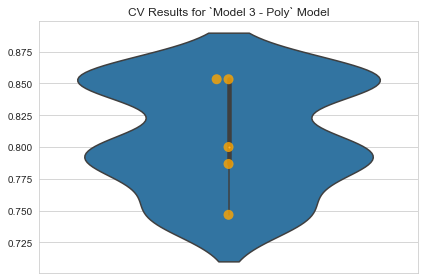

In [69]:
# Saving variable for convenience
model_results = my_model_results

# Plot CV results
fig, ax = plt.subplots()
ax = model_results.plot_cv(ax)
plt.tight_layout();
# Print CV results
model_results.print_cv_summary()

Minimal improvement...

### Model 4

Let's see different regularization penalties.

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=77)
C_values = [0.0001,0.001,0.01,0.1,1]

for c in C_values:
    my_model_reg = LogisticRegression(random_state = 77, C=c, max_iter=1000)

    my_model_reg.fit(X_train, y_train)
    my_model_reg.predict(X_train)

    my_model_reg.fit(X_train, y_train)
    
    my_model_reg_results = ModelWithCV(
                        model=my_model_reg,
                        model_name=f'Model 4 - Reg C={c:e}',
                        X=X_train, 
                        y=y_train
)
    # Saving variable for convenience
    model_results = my_model_reg_results

    # Print CV results
    model_results.print_cv_summary()


CV Results for `Model 4 - Reg C=1.000000e-04` model:
            0.73867 ± 0.01360 accuracy
        
CV Results for `Model 4 - Reg C=1.000000e-03` model:
            0.74400 ± 0.01555 accuracy
        
CV Results for `Model 4 - Reg C=1.000000e-02` model:
            0.73600 ± 0.02585 accuracy
        
CV Results for `Model 4 - Reg C=1.000000e-01` model:
            0.77067 ± 0.03617 accuracy
        
CV Results for `Model 4 - Reg C=1.000000e+00` model:
            0.79467 ± 0.04349 accuracy
        


In [71]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=77)

my_model_reg = LogisticRegression(random_state = 77, C=.1, max_iter=1000)

my_model_reg.fit(X_train, y_train)
my_model_reg.predict(X_train)

my_model_reg.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=1000, random_state=77)

In [72]:
my_model_results = ModelWithCV(
                        model=my_model_reg,
                        model_name='Model 4 - Reg C=.1',
                        X=X_train, 
                        y=y_train
)

CV Results for `Model 4 - Reg C=.1` model:
            0.77067 ± 0.03617 accuracy
        


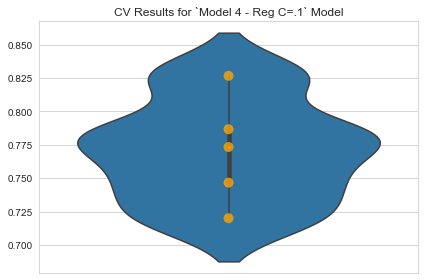

In [73]:
# Saving variable for convenience
model_results = my_model_results

# Plot CV results
fig, ax = plt.subplots()
ax = model_results.plot_cv(ax)
plt.tight_layout();
# Print CV results
model_results.print_cv_summary()

In [74]:
sorted(list(zip(X_train.columns, my_model_reg.coef_[0])),
       key=lambda x: abs(x[1]), reverse=True)

[('champLevel', 0.9079535522107729),
 ('csPerMin', -0.6415766344158274),
 ('visionWardsBoughtInGame', 0.1325477682031775),
 ('teamColor_isBlue', 0.10568991164856932),
 ('firstBloodKill', -0.05895036986374942),
 ('gameDuration', -0.01083841079785863),
 ('goldEarned', 0.0009476222609775081),
 ('longestTimeSpentLiving', -0.0005654231929396532),
 ('totalDamageDealtToChampions', -9.746536873240366e-05)]

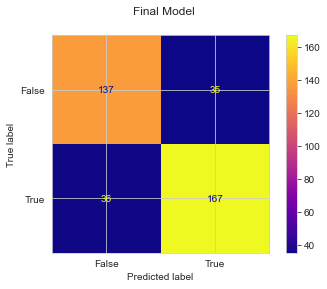

In [75]:
fig, ax = plt.subplots()

fig.suptitle("Final Model")

plot_confusion_matrix(my_model_reg, X_train, y_train, ax=ax, cmap="plasma");

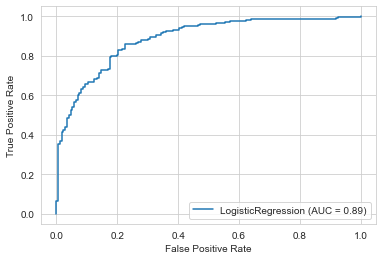

In [76]:
plot_roc_curve(my_model_reg,X_train,y_train)

In [77]:
# Let's get predictions for training & testing sets
y_hat_train = my_model_reg.predict(X_train)
y_hat_test = my_model_reg.predict(X_test)


# Was our model correct?
residuals = y_train == y_hat_train

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

print('\n','-'*30,'\n')

print('Percentage of values correctly predicted: ')
print(pd.Series(residuals).value_counts(normalize=True))

Number of values correctly predicted:
True     304
False     71
Name: win, dtype: int64

 ------------------------------ 

Percentage of values correctly predicted: 
True     0.810667
False    0.189333
Name: win, dtype: float64


In [78]:
#test set
residuals = y_test == y_hat_test

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

print('\n','-'*30,'\n')

print('Percentage of values correctly predicted: ')
print(pd.Series(residuals).value_counts(normalize=True))

Number of values correctly predicted:
True     107
False     18
Name: win, dtype: int64

 ------------------------------ 

Percentage of values correctly predicted: 
True     0.856
False    0.144
Name: win, dtype: float64


### Decision Tree Method

In [79]:
# Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=29, test_size=.2)

In [80]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=3, random_state=29) 

tree_clf.fit(X_train , y_train)

DecisionTreeClassifier(max_depth=3, random_state=29)

In [81]:
from sklearn.metrics import accuracy_score
y_pred = tree_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.64

# PCA

In [82]:
X_test

,gameDuration,totalDamageDealtToChampions,goldEarned,champLevel,longestTimeSpentLiving,teamColor_isBlue,visionWardsBoughtInGame,firstBloodKill,csPerMin
165,2041,30302,15452,18,421,0,4,0,6.320431
272,1643,13328,8547,14,589,1,2,0,5.952526
191,1749,17536,10509,15,314,0,3,0,5.145798
405,1602,14802,9489,14,449,1,1,1,6.142322
29,1481,10165,12202,15,746,0,3,0,6.482107
...,...,...,...,...,...,...,...,...,...
166,1476,6778,8359,13,586,1,3,0,5.813008
141,1673,13454,12015,15,849,0,2,0,7.387926
28,968,4846,3899,10,419,1,0,0,4.896694
38,1510,10474,9869,15,367,1,2,1,5.364238


In [83]:
from sklearn.preprocessing import StandardScaler

X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

In [85]:
from sklearn.decomposition import PCA


for i in range(1,10):
    pca = PCA(n_components=i)
    
    X_train_scaled_pce = pca.fit_transform(X_train_scaled)
    
    lr_pca = LogisticRegression()
    lr_pca.fit(X_train_scaled_pce, y_train)
    print('n =', i, lr_pca.score(X_train_scaled_pce, y_train))

n = 1 0.595
n = 2 0.5925
n = 3 0.6075
n = 4 0.61
n = 5 0.6225
n = 6 0.62
n = 7 0.6425
n = 8 0.8425
n = 9 0.84
